### In this notebook, I will be tackling the Take Home Data Science Challenge for Relax Inc. as part of exercise for Springboard Data Science Career Intensive Program. 

Data:

takehome_user_engagement.csv: has a row for each day that a user logged into the product
takehome_users.csvdata on 12,000 users who signed up for the product in the last two years

Objective:

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period , identify which factors predict future user adoption.

In [1]:
# let's beging by importing relevant libraries for loading/reading in the csv files, data cleaning and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Will likely need to clean/munge and manipulate the user_engagement table first which will be congruent to an SQL sub-query in which to join to the users table/dataset to apply a class label (active/non-active) for further analysis and predictiona model construction.

In [2]:
# load in the user engagements table and let's explore...
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
# the time_stamp column is a datetime format but read in as an object. let's convert and make this converted data into our index

engagement = pd.read_csv('takehome_user_engagement.csv', parse_dates=[0])
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [5]:
engagement.set_index(engagement['time_stamp'], inplace=True)
engagement.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [6]:
engagement.tail()

,time_stamp,user_id,visited
time_stamp,,,
2013-09-06 06:14:15,2013-09-06 06:14:15,11996,1
2013-01-15 18:28:37,2013-01-15 18:28:37,11997,1
2014-04-27 12:45:16,2014-04-27 12:45:16,11998,1
2012-06-02 11:55:59,2012-06-02 11:55:59,11999,1
2014-01-26 08:57:12,2014-01-26 08:57:12,12000,1


In [7]:
# it also doesn't appear we have any missing data or null values... let's check anyway

engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [8]:
# let's also see how many uniquer userids there are...

engagement['user_id'].nunique()

8823

In [9]:
# does the visited column have any variation, or perhaps a binary classification.  

engagement['visited'].unique()

# looks like it doesn't tell us anything but provides a count. 

array([1], dtype=int64)

Let us now label the users in this data as "adopted user" or "not adopted" given the condition that a user has logged into the product on three separate days in at least one seven-day period.

It seems the best way to calculate this in the data would be to group by user, then by 7 day intervals, then assigning a label as "adopted user" if the aggregated 'visited' count is >= 3 and labelling as "not adopted" if this count is <3.  

In [10]:
# drop the extra time_stamp column

engagement.drop('time_stamp', axis=1, inplace=True)


In [11]:
engagement.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [12]:
pivot = engagement.groupby(by=['user_id', pd.Grouper(freq='7D')]).sum()

In [13]:
pivot.head()

visited
user_id time_stamp                  
1       2014-04-17 08:20:06        1
2       2013-11-14 08:20:06        1
        2013-11-28 08:20:06        1
        2013-12-05 08:20:06        1
        2013-12-19 08:20:06        1

In [14]:
# further aggregate so that user is is associated with the max number of visits in a 7 day window (not assuming rolling 7 day)
user_adoption = pivot.groupby(level=0).visited.max().reset_index(name='max_weekly_visits')

In [15]:
# setting the user_id as index for later join

user_adoption.set_index('user_id', inplace=True)
user_adoption.tail()

,max_weekly_visits
user_id,
11996,1
11997,1
11998,1
11999,1
12000,1


In [16]:
# create new column with value that classifies user as an "adopted user" or not.  1 = "adopted user", 0= "not adopted"

user_adoption['adoption'] = user_adoption['max_weekly_visits'] >= 3
user_adoption['adoption'] = user_adoption['adoption'].astype(int)
user_adoption.tail(15)

,max_weekly_visits,adoption
user_id,,
11983,1,0
11984,1,0
11986,1,0
11987,1,0
11988,5,1
11989,1,0
11990,1,0
11991,2,0
11992,1,0


In [17]:
user_adoption.info()

# this suggests there are only 8823 users (down from 207917 total timestamps per user)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 2 columns):
max_weekly_visits    8823 non-null int64
adoption             8823 non-null int32
dtypes: int32(1), int64(1)
memory usage: 172.3 KB


In [18]:
adoption_ratio = (user_adoption['adoption'].sum()/user_adoption['adoption'].count())
print('Only {:.2f}% of users are considered as adopted users.'.format(adoption_ratio*100))

Only 16.31% of users are considered as adopted users.


In [19]:
# import character detection module as csv fails to properly interpret csv file data
import chardet

In [20]:
with open("takehome_users.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

In [21]:
print(result)

{'language': '', 'encoding': 'ISO-8859-1', 'confidence': 0.73}


In [22]:
# lets load in, clean and examine the users table.  After that, will join the adoption label (remember to check for class imabalance)
# per the character detection module, file contains ISO-8859-1 encoding.
users = pd.read_csv('takehome_users.csv', sep=",", encoding='ISO-8859-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [23]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


With a quick glance at the table and the table details, appears the following cleaning/munging will be needed:
 Convert creation_time to datetime
 Creation_source will need to be one-hot encoded
 
Other notes:
Object_id is User ID.
We don't need to clean: name, email, invited by user_id since these are likely not predictors (may choose to use regex to extract email domain as a possible feature).
Last_session_creation_time: this likely doesn't count the initial sign up.  So any null values, we can label as "0".

In [24]:
# set user as index for joining

users.set_index('object_id', inplace=True)

In [25]:
combined = pd.merge(users, user_adoption, how='left', left_index=True, right_index=True)
combined.index.name = 'user_id'
combined.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,max_weekly_visits,adoption
user_id,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0,0.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,3.0,1.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0,0.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0,0.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0,0.0


In [26]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
max_weekly_visits             8823 non-null float64
adoption                      8823 non-null float64
dtypes: float64(4), int64(3), object(4)
memory usage: 1.4+ MB


In [27]:
combined.loc[combined['last_session_creation_time'].isnull()].head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,max_weekly_visits,adoption
user_id,,,,,,,,,,,
8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN,NaN
9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN,NaN
12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0,NaN,NaN
15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,175,NaN,NaN,NaN
16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,211,NaN,NaN,NaN


In [28]:
# let's fill in Nulls for adoption as 0 and max_weekly_visits as 1/

combined['adoption'].fillna(0, inplace=True)
combined['max_weekly_visits'].fillna(1, inplace=True)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
max_weekly_visits             12000 non-null float64
adoption                      12000 non-null float64
dtypes: float64(4), int64(3), object(4)
memory usage: 1.4+ MB


In [29]:
# drop columns that likely won't be useful including name, email, last_session_creation_time, and invited_by_user_id
# also convert creation_time to datetime
combined.drop(['name','email', 'last_session_creation_time','invited_by_user_id'], axis=1, inplace=True)
combined['creation_time'] = pd.to_datetime(combined['creation_time'], errors='raise', infer_datetime_format=True)
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
creation_time                 12000 non-null datetime64[ns]
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
max_weekly_visits             12000 non-null float64
adoption                      12000 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 1.0+ MB


In [30]:
# one-hot encode the creation_source column

combined_w_dummies = pd.get_dummies(combined, columns=['creation_source'])
combined_w_dummies.head()

,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,max_weekly_visits,adoption,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,
1,2014-04-22 03:53:30,1,0,11,1.0,0.0,1,0,0,0,0
2,2013-11-15 03:45:04,0,0,1,3.0,1.0,0,1,0,0,0
3,2013-03-19 23:14:52,0,0,94,1.0,0.0,0,1,0,0,0
4,2013-05-21 08:09:28,0,0,1,1.0,0.0,1,0,0,0,0
5,2013-01-17 10:14:20,0,0,193,1.0,0.0,1,0,0,0,0


org_id may not be a significant predictor but let's explore this visually...

In [31]:
len(combined['org_id'].unique())

417

In [32]:
orgs = combined.groupby(by='org_id').count()
orgs.head()

,creation_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,max_weekly_visits,adoption
org_id,,,,,,
0,319,319,319,319,319,319
1,233,233,233,233,233,233
2,201,201,201,201,201,201
3,168,168,168,168,168,168
4,159,159,159,159,159,159


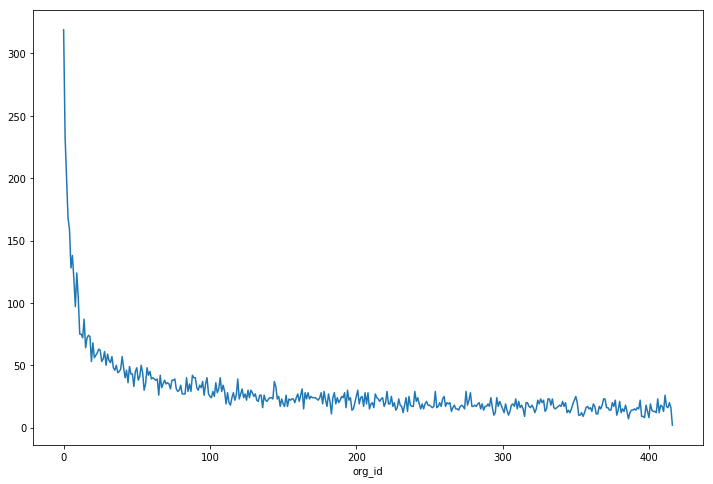

In [33]:
orgs['adoption'].plot(figsize=(12,8))
plt.show()

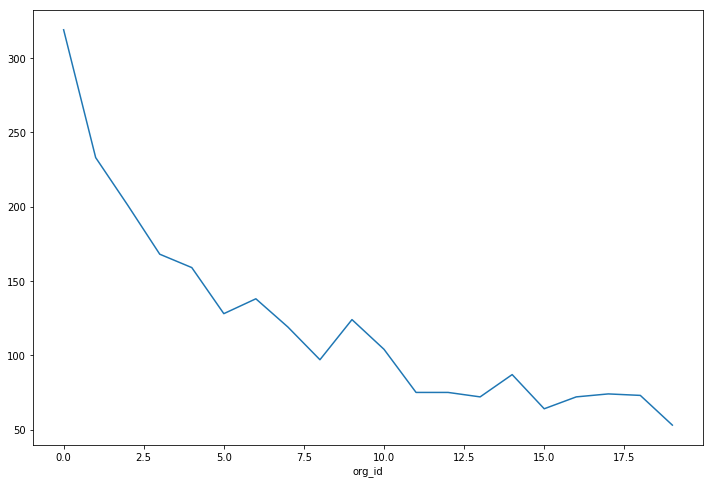

In [34]:
orgs['adoption'][:20].plot(figsize=(12,8))
plt.show()

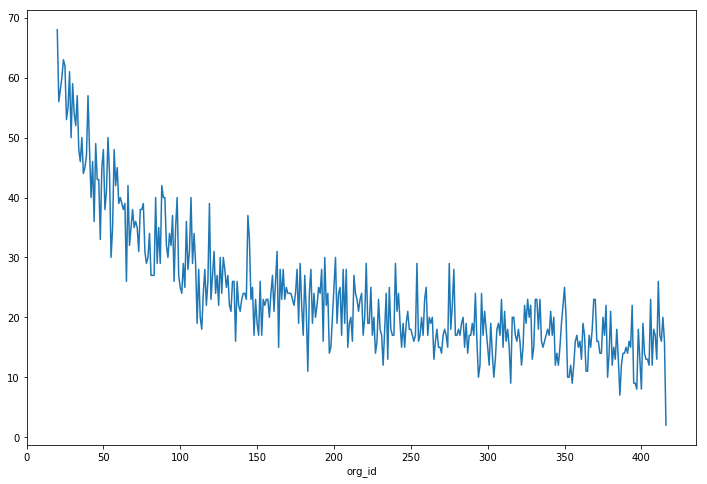

In [35]:
orgs['adoption'][20:].plot(figsize=(12,8))
plt.show()

In [36]:
orgs['adoption'].median()

22.0

Org ID's 0-10 can be internal user testing groups and should be omitted as the inclusion can result in substantial class imabalance for a predictive model (and result in undesirably overweight of the org_id feature, if we were to include it). 

To reiterate, I am assuming that a users organization id is unlikely a factor to predict future user adoption.  We would drill down further and examine metrics like "adoption rate per org" but may be beyond of this analysis.

In [37]:
# drop rows where orig_id = [range(10)]

combined_w_dummies = combined_w_dummies[combined_w_dummies.org_id > 10]
combined_w_dummies.info()

# ouch we lost about 1800 rows or 15% of our data. we may include this back in later.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10210 entries, 1 to 11998
Data columns (total 11 columns):
creation_time                         10210 non-null datetime64[ns]
opted_in_to_mailing_list              10210 non-null int64
enabled_for_marketing_drip            10210 non-null int64
org_id                                10210 non-null int64
max_weekly_visits                     10210 non-null float64
adoption                              10210 non-null float64
creation_source_GUEST_INVITE          10210 non-null uint8
creation_source_ORG_INVITE            10210 non-null uint8
creation_source_PERSONAL_PROJECTS     10210 non-null uint8
creation_source_SIGNUP                10210 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    10210 non-null uint8
dtypes: datetime64[ns](1), float64(2), int64(3), uint8(5)
memory usage: 608.2 KB


In [38]:
# given this refined dataset, let's find our features using Recursive Feature Elimination (RFE) using SciKit Learn

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression # will begin using a simple Logistic model since we have a binary classification
from sklearn.model_selection import train_test_split

In [39]:
X = combined_w_dummies.drop(['creation_time','adoption'], axis=1) #creation_time (as datetime datatype) can't be used for log reg
y = combined_w_dummies['adoption']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [48]:
model = LogisticRegression()
rfe = RFE(model, 5) #let's just keep the top 5 features

rfe = rfe.fit(X_train, y_train)

In [49]:
features_selected = rfe.support_ 
features_selected_rank = rfe.ranking_ #gives ranking of feature (lower is better)
print(features_selected)
print(features_selected_rank)

#dict= [{k:[v,x]} for k,v,x in zip(X.columns, features_selected,features_selected_rank)]

[False False False  True  True  True  True  True False]
[3 4 5 1 1 1 1 1 2]


In [50]:
features = pd.DataFrame({'Feature_Selected':features_selected, 'Feature_Rank': features_selected_rank }, index=X.columns)
#features.pivot(index=features.columns, columns=['feature_selected, feature_ranking'], values=[features_selected,features_selected_rank])
features = features.sort_values('Feature_Rank')
features

,Feature_Rank,Feature_Selected
max_weekly_visits,1,True
creation_source_GUEST_INVITE,1,True
creation_source_ORG_INVITE,1,True
creation_source_PERSONAL_PROJECTS,1,True
creation_source_SIGNUP,1,True
creation_source_SIGNUP_GOOGLE_AUTH,2,False
opted_in_to_mailing_list,3,False
enabled_for_marketing_drip,4,False
org_id,5,False


Given that the higher ranking (the lower the number), the above table suggests that the creation_source is a key factor in prediction future user adoption.  I further suspect that if 'max_weekly_visits' was omitted, the last creation source would have actually been "True" and had a ranking of 1 (as opposed to False and 2).  The creation source is likely a proxy for the main platform which a user accesses the product.  The type of platform then is a predictor whether a user will convert to "adopted" status.  The implication is that these access-types (limited permission or full member) or platforms can be improved in a way to drive up overall adoption (by pin-pointing which platforms are successful or not-successful in conversion).

I also forgot to rescale the org_id (possible from 0 - 1) as to not outweigh the one-hot encoding values but it doesn't appear to be used by the RFE algo.

In [51]:
# just for kicks let's see how well the model performs

print(rfe.score(X_test, y_test))

1.0
